# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Checking-regression" data-toc-modified-id="Checking-regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Checking regression</a></div><div class="lev2 toc-item"><a href="#Checking-functions" data-toc-modified-id="Checking-functions-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Checking functions</a></div><div class="lev3 toc-item"><a href="#Generate-boxes" data-toc-modified-id="Generate-boxes-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Generate boxes</a></div><div class="lev3 toc-item"><a href="#Generate-test-dataset" data-toc-modified-id="Generate-test-dataset-112"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Generate test dataset</a></div><div class="lev3 toc-item"><a href="#Conv-net-definitions" data-toc-modified-id="Conv-net-definitions-113"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Conv net definitions</a></div><div class="lev3 toc-item"><a href="#Generate-Default-boxes" data-toc-modified-id="Generate-Default-boxes-114"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Generate Default boxes</a></div><div class="lev3 toc-item"><a href="#Center-to-coords" data-toc-modified-id="Center-to-coords-115"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Center to coords</a></div><div class="lev3 toc-item"><a href="#Draw-boxes" data-toc-modified-id="Draw-boxes-116"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Draw boxes</a></div><div class="lev3 toc-item"><a href="#Get-prediction-boxes" data-toc-modified-id="Get-prediction-boxes-117"><span class="toc-item-num">1.1.7&nbsp;&nbsp;</span>Get prediction boxes</a></div><div class="lev3 toc-item"><a href="#Draw-predicted-boxes" data-toc-modified-id="Draw-predicted-boxes-118"><span class="toc-item-num">1.1.8&nbsp;&nbsp;</span>Draw predicted boxes</a></div><div class="lev3 toc-item"><a href="#Normalize-shifts" data-toc-modified-id="Normalize-shifts-119"><span class="toc-item-num">1.1.9&nbsp;&nbsp;</span>Normalize shifts</a></div><div class="lev3 toc-item"><a href="#Regression-loss" data-toc-modified-id="Regression-loss-1110"><span class="toc-item-num">1.1.10&nbsp;&nbsp;</span>Regression loss</a></div><div class="lev3 toc-item"><a href="#Get-aspect-ratio" data-toc-modified-id="Get-aspect-ratio-1111"><span class="toc-item-num">1.1.11&nbsp;&nbsp;</span>Get aspect ratio</a></div><div class="lev3 toc-item"><a href="#Do-the-matching" data-toc-modified-id="Do-the-matching-1112"><span class="toc-item-num">1.1.12&nbsp;&nbsp;</span>Do the matching</a></div><div class="lev4 toc-item"><a href="#IOU-cpu" data-toc-modified-id="IOU-cpu-11121"><span class="toc-item-num">1.1.12.1&nbsp;&nbsp;</span>IOU cpu</a></div><div class="lev4 toc-item"><a href="#Find-matching-indices" data-toc-modified-id="Find-matching-indices-11122"><span class="toc-item-num">1.1.12.2&nbsp;&nbsp;</span>Find matching indices</a></div><div class="lev3 toc-item"><a href="#Eveyrthing-connected" data-toc-modified-id="Eveyrthing-connected-1113"><span class="toc-item-num">1.1.13&nbsp;&nbsp;</span>Eveyrthing connected</a></div><div class="lev2 toc-item"><a href="#Experiments" data-toc-modified-id="Experiments-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Experiments</a></div>

# Checking regression 

The strategy will be to check regression in x and y and see how that works out when you combine it. Clearly something must be amiss. So the list of things to do is the following - 


1) check regression in x 

2) check regression in y 

3) check regression when you combine both

4) For all of this you need to check each function to make sure that it is doing what its supposed to do




## Checking functions 

### Generate boxes

First attempt chose a static box to see what is going on,  you will replicate the code for random boxes

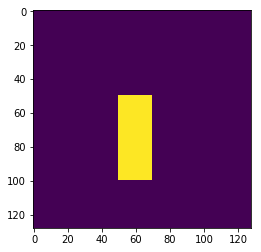

In [1]:
import chainer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import random 
from chainer.functions import log, hstack, huber_loss

# %matplotlib notebook
def get_single_image(pos_r, pos_c, height, width  ): 
    
    image = np.zeros((1,3,128,128), dtype=np.float32)

    gts = []

    for i in range(1):
        # Choose random coordinate, this can also be run in a loop
        width = width
        height =height
        pos_r =pos_r
        pos_c =pos_c
        image[0,:,pos_r:pos_r+height,pos_c:pos_c+width]=1
        #print(pos_r, pos_c)

        cx = pos_c #+ width/2.0
        cy = pos_r #- height/2.0

        box = [cx, cy, width, height, 1, 0]

        gts.append(box)

    # Create ground truth object
    gts2 = chainer.Variable(np.array(gts, dtype=np.float32))
    return gts2, image 


gt, img  = get_single_image(50,50, 50,20)
for i in range(1):
    # Initialize the image
    
    # Visualize the entire thing
    plt.imshow(img[0,0,:,:])
    plt.show()

In [2]:
print('ground truth box coordinates: ' ,gt,'gt shape :' ,gt.shape)
print('-----------------------------------------------')
print('Image shape', img.shape)


ground truth box coordinates:  variable([[ 50.  50.  20.  50.   1.   0.]]) gt shape : (1, 6)
-----------------------------------------------
Image shape (1, 3, 128, 128)


### Generate test dataset

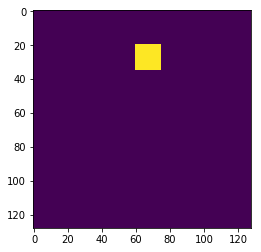

In [3]:
def generate_test_set():
    
    image_sizes = [10,15,20,25,30,35,40,45,50,55,60]
    locx =[20,20,30,30,40,40,50, 60,60,60,60]
    locy = [60,60,30,30,40,60,50, 45,45,50,50]
    test_gts = []
    imgs = []
    
    for i in range(len(locx)): 

        image = np.zeros((1,3,128,128), dtype=np.float32)
        # Choose random coordinate, this can also be run in a loop
        width = image_sizes[i]
        height =image_sizes[i]
        pos_r =locx[i]
        pos_c =locy[i]
        image[0,:,pos_r:pos_r+height,pos_c:pos_c+width]=1
        #print(pos_r, pos_c)

        cx = pos_c #+ width/2.0
        cy = pos_r #- height/2.0

        box = [cx, cy, width, height, 1, 0]

        test_gts.append(box)
        imgs.append(image)
    # Create ground truth object
    test_gts2 = chainer.Variable(np.array(test_gts, dtype=np.float32))
    return test_gts2, imgs 

test_gts, test_imgs = generate_test_set()
test_gts

img_test = test_imgs[1]

plt.imshow(img_test[0,0,:,:])


plt.show()


### Conv net definitions 

In [4]:
from chainer import Chain
import chainer
import chainer.functions as F
import chainer.links as L

class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__(
            l1=L.Convolution2D(None,32,ksize=(3,3),stride=1,pad=1),
            l2=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l3=L.DilatedConvolution2D(32,32,ksize=(5,5),stride=1,pad=1),
            l4=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l5=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),    
            l6=L.DilatedConvolution2D(32,32,ksize=(7,7),stride=1,pad=1),
            l7=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l8=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1)
            
        )
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2= F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
#         h4 = F.max_pooling_2d(h3, 2)
        
        h5 = F.relu(self.l4(h3))
        h6= F.relu(self.l5(h5))
        h7 = F.relu(self.l6(h6))
        h8 = F.relu(self.l7(h7))
       
        
#         h8 = F.max_pooling_2d(h7, 2)
#         h5 = F.relu(self.l3(h4))
#         h6 = F.max_pooling_2d(h5, 2)
#         h7 = F.relu(self.l4(h6))
        
        return self.l8(F.sigmoid(h8))
    

In [5]:
class BoxNet(Chain):
    def __init__(self, predictor):
        super(BoxNet, self).__init__(
            l1=L.Convolution2D(None,6,ksize=(3,3),stride=1,pad=1)
        )
        self.predictor = predictor
        
    def __call__(self, x):
        h1 = self.l1(self.predictor(x))
        return h1
    
convnet = ConvNet()
boxnet = BoxNet(ConvNet())
fm = convnet(img)
shifts_all = boxnet(img)

shifts= shifts_all[:,:,64,64]
shifts =F.reshape(shifts,[1,6,1,1])
shifts_all.shape

(1, 6, 122, 122)

In [6]:
print('shifts all shape :', shifts_all.shape,  ' \n shifts shape :', shifts.shape)
print('------------------------------------------')
print('shifts value :', shifts[0])

shifts all shape : (1, 6, 122, 122)  
 shifts shape : (1, 6, 1, 1)
------------------------------------------
shifts value : variable([[[-0.3497481 ]]

          [[-0.40797982]]

          [[-0.07878644]]

          [[-1.39140987]]

          [[ 0.38245082]]

          [[ 0.42977697]]])


### Generate Default boxes

In [7]:
def defaultgen(I, F, width, height):
    """
    Generates an array of default boxes: Chainer TESTED
    
    Args:
        I: Input image tensor (N,channels,rows,cols)
        F: Feature map tensor to generate default boxes for
        width: Width of the box
        height: Height of the box
        
    Returns:
        db: Default boxes tensor, flattened
    """
    scale = (I.shape[2] / F.shape[2])
    offset = np.ones((2,F.shape[2],F.shape[3]), dtype=np.float32)
    iterator = np.flip(np.indices((F.shape[2],F.shape[3])), axis=0).astype(np.float32)
    
    xys = offset * ((scale-1)/2) + iterator * scale
    xys = np.moveaxis(xys,0,2)
    ws = np.full((F.shape[2],F.shape[3],1), width, dtype=np.float32)
    hs = np.full((F.shape[2],F.shape[3],1), height,dtype=np.float32)
    class_scores = np.zeros((F.shape[2],F.shape[3],2), dtype=np.float32)
    db = np.dstack([xys, ws, hs, class_scores])
   
    db = db[64,64,:]
    db = db.reshape([1,1,6])
    
    return chainer.Variable(db.reshape((db.shape[0] * db.shape[1], 6)))


In [8]:
def_boxes = defaultgen(img,fm, 60,60)
print('def_boxes values:', def_boxes)
print('---------------------------------------')
print('print shape of def boxes :', def_boxes.shape)

def_boxes values: variable([[ 67.17212677  67.17212677  60.          60.           0.           0.        ]])
---------------------------------------
print shape of def boxes : (1, 6)


### Center to coords 

This function has been checked, seems correct, some examples below

In [9]:
def center_to_coords(box):
    """ 
    Converts bounding box from (cx, cy, w, h) format to (x1, y1, x2, y2) format
    
    Args:
        box: 6d numpy array
        
    Returns:
        box_transformed: Box in the second format
    
    """
    box_transformed = np.array([box[0]-box[2]/2.0, box[1]-box[3]/2.0, box[0]+box[2]/2.0, box[1]+box[3]/2.0, box[4], box[5]])
    return box_transformed



Checking center to coords...

In [10]:
center_to_coords(def_boxes[0])

array([variable(37.17212677001953), variable(37.17212677001953),
       variable(97.17212677001953), variable(97.17212677001953),
       variable(0.0), variable(0.0)], dtype=object)

In [11]:
# some more checks 

box1= np.array([10,9, 3,3,0,0])
box2= np.array([90,15, 33,33,0,0])

print(center_to_coords(box2), center_to_coords(box1)) 

[  73.5   -1.5  106.5   31.5    0.     0. ] [  8.5   7.5  11.5  10.5   0.    0. ]


### Draw boxes 


In [12]:
def draw_boxes(image, boxes):
    img = image
    plt.figure()
    ax = plt.axes()

    for box in boxes:
        box = center_to_coords(box.data)
        ax.imshow(img[0,0,:,:])
        p = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color = 'red')
        ax.add_patch(p)

    
    return ax
ax  = draw_boxes(img, def_boxes)

### Get prediction boxes 

This seems to be correct as well

In [13]:
def get_pred_boxes(shift_vals, default_boxes ): 
    """
    Get predicted boxes by combining shift values to default boxes
    Input: 

    shift_values : Shifts generated by the network  NDarray (None, Num of Default boxes, 4+num of classes)
    Default boxes  : Default boxes generated by the network NDarray (None, Num of Default boxes, 4+num of classes)

    Output: 

    Predicted boxes  : Predicted boxes, same shape as default boxes  NDarray (None, Num of Default boxes, 4+num of classes)

    """
    
    shift_val_shape= default_boxes.shape
    shift_vals= F.swapaxes(shift_vals,1,3)
    shift_vals= F.reshape(shift_vals,shift_val_shape)
    
    shifts = shift_vals 
    def_boxes= default_boxes
    
    
    cx_pred = (shifts[:,0]*def_boxes[:,2])+def_boxes[:,0]
    cy_pred = (shifts[:,1]*def_boxes[:,3])+def_boxes[:,1]
    
    H_pred = F.exp(shifts[:,3])*def_boxes[:,3]
    W_pred = F.exp(shifts[:,2])*def_boxes[:,2]
    
    class1 = shifts[:,4]
    class2 = shifts[:,5]
    
    
    pred_boxes = F.vstack((cx_pred,cy_pred,W_pred,H_pred, class1, class2))
    pred_boxes = F.transpose(pred_boxes)
    
    return  pred_boxes 

In [14]:
pred_boxes= get_pred_boxes(shifts, def_boxes)
print('prediction box coordinates :', pred_boxes)

prediction box coordinates : variable([[ 46.1872406   42.69333649  55.45423889  14.92346287   0.38245082
             0.42977697]])


In [15]:
shifts

variable([[[[-0.3497481 ]],

           [[-0.40797982]],

           [[-0.07878644]],

           [[-1.39140987]],

           [[ 0.38245082]],

           [[ 0.42977697]]]])

In [16]:
def_boxes

variable([[ 67.17212677,  67.17212677,  60.        ,  60.        ,
             0.        ,   0.        ]])

### Draw predicted boxes

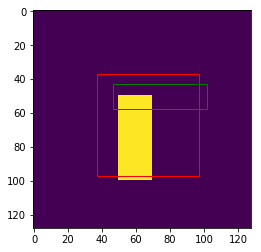

In [17]:

def draw_pred_boxes(prediction_boxes,img, ax): 
    """Draw predicted boxes on the original image """
    box =prediction_boxes
    
    for box in prediction_boxes:
        box2= box.data
        box = center_to_coords(box.data)
        ax.imshow(img[0,0,:,:])
        p = patches.Rectangle((box2[0], box2[1]), box[2]-box[0], box[3]-box[1], fill=False, color = 'green')
        ax.add_patch(p)


    plt.show()

draw_pred_boxes(pred_boxes, img, ax)

### Normalize shifts     

In [18]:

def normalize_shift(box, def_box):
    """
    Scales down absolute shifts, % for centers, log for height and width.
    
    Args:
        box: 6x1 bounding box coordinates
        def_box: 6x1 reference box coordinates
        
    Returns:
        normalized_shift_vector: 4x1 normalized shift vector. Note that we discard the last 2 channels.
    """
    tx = (box[0] - def_box[0])/def_box[2]
    ty = (box[1] - def_box[1])/def_box[3]
    tw = log(box[2]/def_box[2])
    th = log(box[3]/def_box[3])
    
    return hstack([tx, ty, tw, th])
    

### Regression loss 

This too seems to work 

In [19]:
def regression_loss(pred_box, gt_box, def_box):
    """
    Calculates regression loss between two boxes w.r.t a reference default box.
    
    Args:
        pred_box: 6x1 bounding box predicted by the network
        gt_box: 6x1 bounding box overlapping with pred_box
        def_box: 6x1 bounding box with same index as pred_box
        
    Returns:
        reg_loss: Scalar of huber loss between two vectors
    """
    
    gt_normalized  = normalize_shift(gt_box[0],def_box[0])
    pred_normalized = normalize_shift(pred_box[0],def_box[0])
  
    gt_normalized = gt_normalized
    pred_normalized = pred_normalized
    gt_normalized = gt_normalized.reshape((1,4))
    pred_normalized = pred_normalized.reshape((1,4))
    # l1 loss 
#     loss_val= pred_normalized - gt_normalized 
#     x_reg = F.absolute(loss_val )
#     x_reg =F.sum(x_reg)
    
    #huber loss 
    return F.huber_loss(gt_normalized,pred_normalized, delta =0.2)
    
    
reg_loss_value = regression_loss(pred_boxes, gt, pred_boxes)
print(' regression loss value :', reg_loss_value)




 regression loss value : variable([ 0.48606834])


In [20]:
def compute_loss(gt_boxes, pred_boxes, def_boxes):
    
    loss_class = chainer.Variable(np.array([0.], dtype=np.float32))
    loss_reg = chainer.Variable(np.array([0.], dtype=np.float32))
    
    gt_box, pred_box, def_box = gt_boxes, pred_boxes, def_boxes    
#     loss_reg += regression_loss(pred_box, gt_box, def_box)
    loss_reg = regression_loss(pred_box, gt_box, def_box)
    
    return loss_reg 


### Get aspect ratio 

In [21]:
def get_aspect_ratios(def_size ):

    def_area = def_size*def_size
    aspect_ratios = [3, 2,0.50, 0.25]
    height_list =[]
    width_list = []

    for i in aspect_ratios: 

        height_list.append(int(def_size*i))  
        width_list.append(int(def_area/(def_size*i)) )

    return height_list,width_list

def_size= 120 
height_list, width_list= get_aspect_ratios(def_size)


print('height list :',height_list)
print('------------------------------')
print('width list :', width_list)

height list : [360, 240, 60, 30]
------------------------------
width list : [40, 60, 240, 480]


### Do the matching 

#### IOU cpu

In [22]:
# Let's define some useful functions first.
# Work with chainer variables for instahook.
#from chainer.functions import max, min, hstack

def iou_cpu(boxA, boxB):
    """
    Calculates intersection over union score of two rectangles, none of them rotated.: TESTED
    
    Args:
        boxA: Box1
        boxB: Box2
        
    Returns:
        iou (scalar): IOU score of the two boxes
    """
        # determine the (x, y)-coordinates of the intersection rectangle
        # Maybe we can accelerate this by writing this as a cython extension
        
    boxA = center_to_coords(boxA)
    boxB = center_to_coords(boxB)
    
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max((xB - xA), 0) * max((yB - yA), 0)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxa_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxb_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    #print(interArea, boxa_area, boxb_area)
    iou = interArea / (boxa_area + boxb_area - interArea)

    # return the intersection over union value
    return iou




#### Find matching indices 

In [23]:
def find_match_indices_cpu(def_box, gt): 
    """
    Find matches between ground truth boxes and boxes predicted by network.
    
    Args:
        gt (): Tensor of ground truth boxes
        pred_boxes (): Tensor of default boxes
        
    Returns:
        pos_inds: Indices of the connectivity matrix where there is a positive match
        neg_inds: Indices of the connectivity matrix where there is a negative match
    """
    
    
    pos_iou_score =  np.zeros((gt.shape[0], def_box.shape[0]), dtype=np.float32)
    neg_iou_score = np.ones((gt.shape[0], def_box.shape[0]), dtype=np.float32)
    iou_score =  np.zeros((gt.shape[0], def_box.shape[0]), dtype=np.float32)
    
    thresh = 0.1
    
    for i in range(gt.shape[0]): 
        for j in range(def_box.shape[0]): 
            iou_score[i,j]  = iou_cpu(gt[i].data, def_box[j].data)
            iou_value =  iou_cpu(gt[i].data, def_box[j].data)
            
            if iou_value > thresh:  
                pos_iou_score[i,j] = iou_value
            else :
                neg_iou_score[i,j] = iou_value
    
    pos_inds  = np.argwhere(pos_iou_score>thresh)
    
    if not pos_inds: 
         pos_inds = np.argwhere(np.max(iou_score))
            
    neg_inds = np.argwhere(neg_iou_score<=thresh)
    
    return  pos_inds, neg_inds,iou_score, pos_iou_score, neg_iou_score


In [24]:
## lets test the above functions 
def_size =120 
height_list, width_list  = get_aspect_ratios(def_size )
def_boxes_all = defaultgen(img,fm,def_size, def_size)
def_box_new = chainer.Variable(np.zeros([1,6],dtype = np.float32) )
def_box_new.copydata(def_boxes_all)

for i in range(len(height_list)): 

    def_box_new.data[0][2:4]=height_list[i], width_list[i]    
    def_boxes_all = F.vstack((def_boxes_all,def_box_new))
    

pos_inds, neg_inds, iou_score, pos_iou_score, neg_iou_score = find_match_indices_cpu(def_boxes_all, gt)
iou_score



array([[ 0.06944445,  0.03749517,  0.05166527,  0.06944445,  0.02607795]], dtype=float32)

### Eveyrthing connected

Now we connect it all and first test x regression, they y regression and then combination of both

could it be that the aspect ratio of a box vs the aspect ratio of the default box have something to do with the loss? 


In [25]:
from chainer.optimizers import SGD,Adam,MomentumSGD
from tqdm import tqdm
import matplotlib.pyplot as plt

def all_connected(posr, posc, width_gt, height_gt, alpha, number_loops, pos_diff):
    """
    Input

    width_gt     : width of the ground truth box 
    height_gt    : height of the ground truth box 
    alpha        : alpha value for the adam optimizer 
    number_loops : number of examples generate


    Ouput 
    Image of the loss function 
    Loss history 
    """

    
    
    boxnet = BoxNet(ConvNet())

    optimizer =Adam(alpha= alpha)
    optimizer.setup(boxnet)
    loss_history = []
    def_size =120 
    height_list, width_list = get_aspect_ratios(def_size)
    width_list=[def_size]
    height_list=[def_size]
    run_number =[]
    size_list =[]
    
    for i in tqdm(range(number_loops)):
        
        width_gt = 60
        height_gt = width_gt
        posy = 30+posdiff
        posr = np.random.randint(30, posy) 
        posc = np.random.randint(30,  posy) 
        
        gt, img =get_single_image(posr, posc, width_gt, height_gt)


        # Initializing the network and computing the features and shifts
        #fm = convnet(img)
        shifts2 = boxnet(img)
        shifts2= shifts2[:,:,64,64]
        shifts2 =F.reshape(shifts2,[1,6,1,1])

        # Getting default_boxes and predictions
        # Forward pass ends here
        loss_total = chainer.Variable(np.array([0.], dtype=np.float32))

        for j in [0]: 
            
            def_boxes2 = defaultgen(img, fm,60 ,60 )
            pred_boxes2 = get_pred_boxes(shifts2, def_boxes2)
            
            loss = compute_loss( gt ,pred_boxes2, def_boxes2)
            loss_total += loss

        if i % 100==0: 
            ax=draw_boxes(img,def_boxes2)
            draw_pred_boxes(pred_boxes2, img, ax)
            print('pred box loc:  ' , pred_boxes2[0][0],pred_boxes2[0][1] )
            print('gt', gt)
        boxnet.zerograds()
        loss_history.append(loss_total.data)
        size_list.append(width_gt)
        
        loss_total.backward()

        optimizer.update()

#     plt.figure(figsize=(30,10))
#     plt.plot(range(len(loss_history)), loss_history)
#     plt.ylim([0,1])
#     plt.show()

    return loss_history, pred_boxes2,def_boxes2,  gt,img, boxnet


In [26]:
def testing_model(model, test_imgs,test_gts): 

    test_pred_boxes_all = []

    for i in range(len(test_imgs)): 
        test_shifts=boxnet(test_imgs[i])
        test_shifts = test_shifts[:,:,64,64]

        test_shifts =F.reshape(test_shifts,[1,6,1,1])
        test_def_boxes = defaultgen(test_imgs[i], fm,height_list[0] ,width_list[0])
        test_pred_boxes = get_pred_boxes(test_shifts, test_def_boxes)
        test_pred_boxes_all.append(test_pred_boxes)

    return test_pred_boxes_all 

In [27]:
height_list, width_list

([360, 240, 60, 30], [40, 60, 240, 480])


## Experiments 

  0%|          | 0/500 [00:00<?, ?it/s]

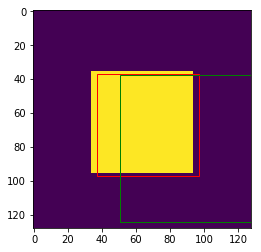

pred box loc:   variable(50.31489562988281) variable(37.687599182128906)
gt variable([[ 34.  36.  60.  60.   1.   0.]])


 20%|██        | 100/500 [00:45<03:00,  2.22it/s]

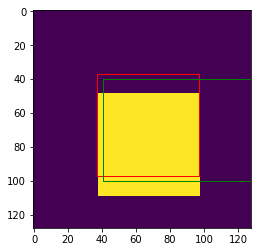

pred box loc:   variable(40.51953887939453) variable(39.9046745300293)
gt variable([[ 38.  49.  60.  60.   1.   0.]])


 40%|████      | 200/500 [01:30<02:15,  2.21it/s]

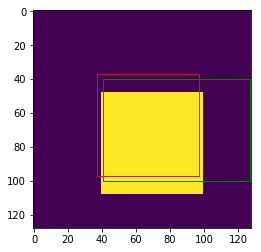

pred box loc:   variable(40.498802185058594) variable(39.79931640625)
gt variable([[ 40.  48.  60.  60.   1.   0.]])


 60%|██████    | 300/500 [02:15<01:27,  2.29it/s]

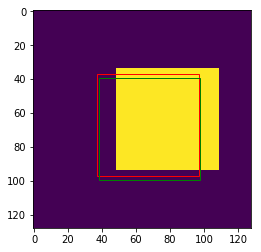

pred box loc:   variable(38.152503967285156) variable(39.307640075683594)
gt variable([[ 49.  34.  60.  60.   1.   0.]])


 80%|████████  | 400/500 [03:00<00:44,  2.24it/s]

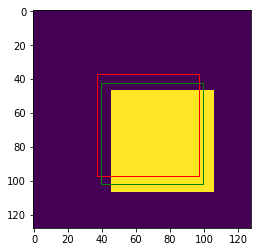

pred box loc:   variable(39.40547180175781) variable(41.99916076660156)
gt variable([[ 46.  47.  60.  60.   1.   0.]])


100%|██████████| 500/500 [03:46<00:00,  2.27it/s]


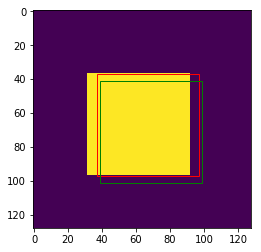

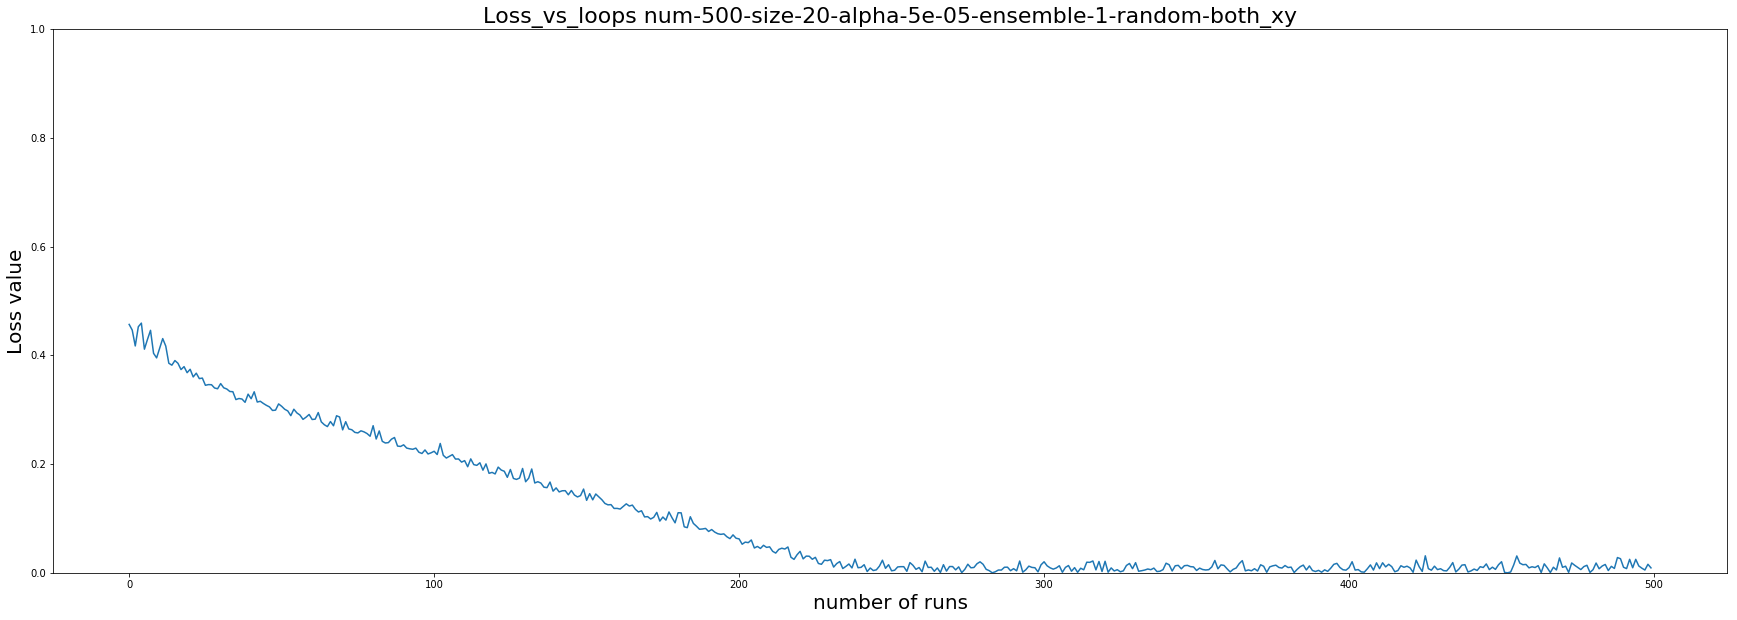

(1, 500, 1)

In [28]:
all_losses = []
alpha = 0.00005
locx= np.random.randint(10, 60) 
locy= np.random.randint(10, 60) 
size= 20
nloops= 500
ensemble = 1
posdiff = 20

for i in range(ensemble): 

    locx= np.random.randint(10, 90) 
    locy= np.random.randint(10, 90) 

    loss_history, pred_boxes, def_boxes, ground_truth, image,boxnet = all_connected(locx,locy, size,size, alpha, nloops, posdiff)
    
    
    ax=draw_boxes(image,def_boxes)
    draw_pred_boxes(pred_boxes, image, ax)
    all_losses.append(loss_history)

    
    random_or_not = 'both_xy'
    plt.figure(figsize=(30,10))
    plt.xlabel('number of runs', size =20)
    plt.ylabel('Loss value', size =20)
    title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
    plt.title(title_name, size=22 )
    plt.ylim([0,1])
    plt.plot(range(len(loss_history)), loss_history)
    # plt.savefig(title_name+'.png')
    plt.show()
    
    
    
    
    
    
    
    
all_losses = np.array(all_losses)
all_losses2 = all_losses.transpose()
all_losses2.shape  




# random_or_not = 'both_xy'
# plt.figure(figsize=(30,10))
# plt.xlabel('number of runs', size =20)
# plt.ylabel('Loss value', size =20)
# title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
# plt.title(title_name, size=22 )
# plt.ylim([0,1])
# plt.plot(range(len(loss_history)), np.mean(all_losses2,axis=1))
# # plt.savefig(title_name+'.png')
# plt.show()

In [29]:
ground_truth

variable([[ 32.,  37.,  60.,  60.,   1.,   0.]])

In [30]:
pred_boxes

variable([[ 39.03769684,  40.9478302 ,  59.99995041,  60.        ,
            -0.11865466,  -0.34280989]])

  0%|          | 0/500 [00:00<?, ?it/s]

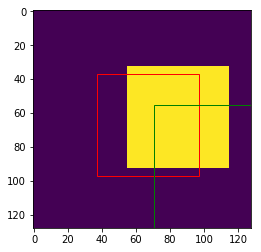

pred box loc:   variable(70.71788024902344) variable(55.28639221191406)
gt variable([[ 55.  33.  60.  60.   1.   0.]])


 20%|██        | 100/500 [00:47<02:58,  2.25it/s]

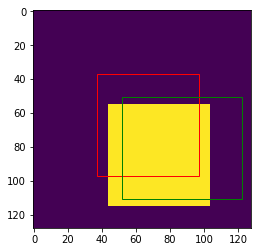

pred box loc:   variable(51.554771423339844) variable(50.686500549316406)
gt variable([[ 44.  55.  60.  60.   1.   0.]])


 40%|████      | 200/500 [01:32<02:13,  2.24it/s]

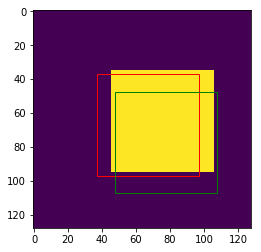

pred box loc:   variable(47.612491607666016) variable(47.3065299987793)
gt variable([[ 46.  35.  60.  60.   1.   0.]])


 60%|██████    | 300/500 [02:17<01:29,  2.25it/s]

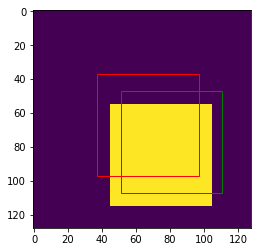

pred box loc:   variable(50.944541931152344) variable(47.20647048950195)
gt variable([[ 45.  55.  60.  60.   1.   0.]])


 80%|████████  | 400/500 [03:02<00:43,  2.29it/s]

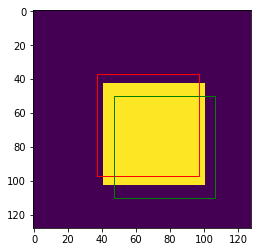

pred box loc:   variable(46.853416442871094) variable(49.81205749511719)
gt variable([[ 41.  43.  60.  60.   1.   0.]])


100%|██████████| 500/500 [03:50<00:00,  2.26it/s]


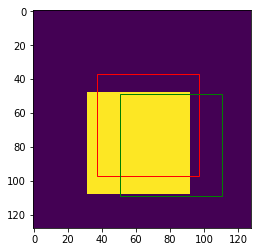

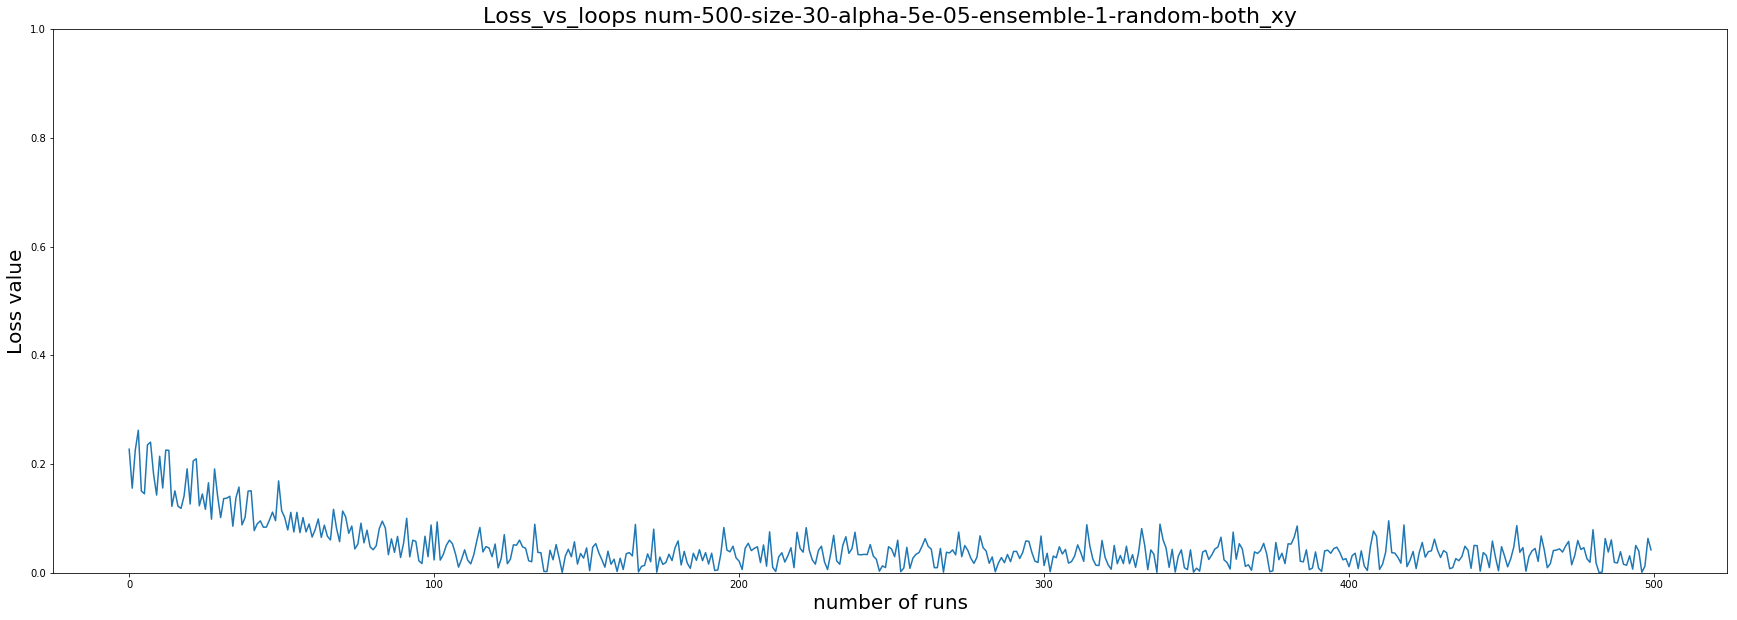

(1, 500, 1)

In [31]:
all_losses = []
alpha = 0.00005
locx= np.random.randint(10, 60) 
locy= np.random.randint(10, 60) 
size= 30
nloops= 500
ensemble = 1
posdiff = 40

for i in range(ensemble): 

    locx= np.random.randint(10, 90) 
    locy= np.random.randint(10, 90) 

    loss_history, pred_boxes, def_boxes, ground_truth, image,boxnet = all_connected(locx,locy, size,size, alpha, nloops, posdiff)
    
    
    ax=draw_boxes(image,def_boxes)
    draw_pred_boxes(pred_boxes, image, ax)
    all_losses.append(loss_history)

    
    random_or_not = 'both_xy'
    plt.figure(figsize=(30,10))
    plt.xlabel('number of runs', size =20)
    plt.ylabel('Loss value', size =20)
    title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
    plt.title(title_name, size=22 )
    plt.ylim([0,1])
    plt.plot(range(len(loss_history)), loss_history)
    # plt.savefig(title_name+'.png')
    plt.show()
    
    
    
    
    
    
    
    
all_losses = np.array(all_losses)
all_losses2 = all_losses.transpose()
all_losses2.shape  


    

  0%|          | 0/500 [00:00<?, ?it/s]

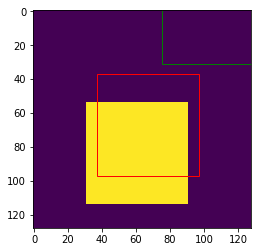

pred box loc:   variable(75.36153411865234) variable(-2.9266281127929688)
gt variable([[ 31.  54.  60.  60.   1.   0.]])


 20%|██        | 100/500 [00:46<03:02,  2.19it/s]

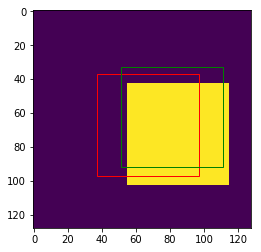

pred box loc:   variable(51.45829772949219) variable(33.03875732421875)
gt variable([[ 55.  43.  60.  60.   1.   0.]])


 40%|████      | 200/500 [01:32<02:16,  2.20it/s]

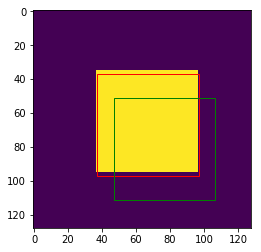

pred box loc:   variable(46.88511657714844) variable(51.201751708984375)
gt variable([[ 37.  35.  60.  60.   1.   0.]])


 60%|██████    | 300/500 [02:19<01:31,  2.18it/s]

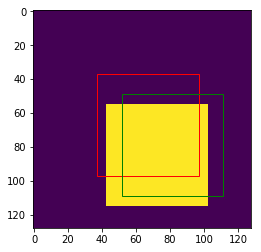

pred box loc:   variable(51.738548278808594) variable(48.80718994140625)
gt variable([[ 43.  55.  60.  60.   1.   0.]])


 80%|████████  | 400/500 [03:06<00:55,  1.81it/s]

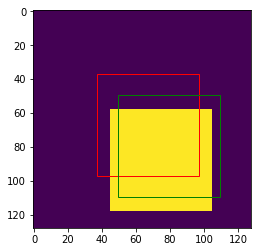

pred box loc:   variable(49.64449691772461) variable(49.40976333618164)
gt variable([[ 45.  58.  60.  60.   1.   0.]])


100%|██████████| 500/500 [03:53<00:00,  2.23it/s]


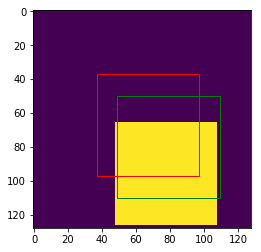

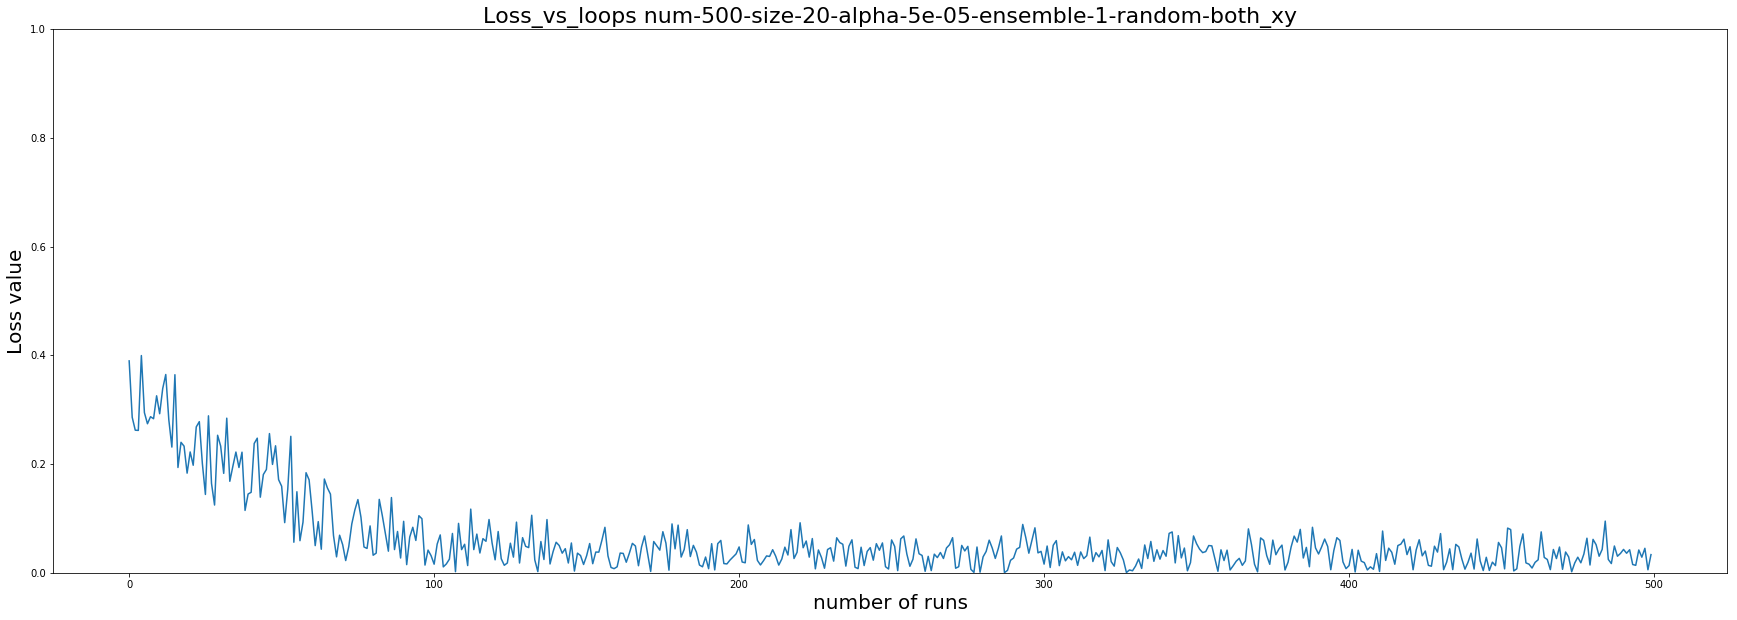

(1, 500, 1)

In [32]:
all_losses = []
alpha = 0.00005
locx= np.random.randint(10, 60) 
locy= np.random.randint(10, 60) 
size= 20
nloops= 500
ensemble = 1
posdiff = 40

for i in range(ensemble): 

    locx= np.random.randint(10, 90) 
    locy= np.random.randint(10, 90) 

    loss_history, pred_boxes, def_boxes, ground_truth, image,boxnet = all_connected(locx,locy, size,size, alpha, nloops, posdiff)
    
    
    ax=draw_boxes(image,def_boxes)
    draw_pred_boxes(pred_boxes, image, ax)
    all_losses.append(loss_history)

    
    random_or_not = 'both_xy'
    plt.figure(figsize=(30,10))
    plt.xlabel('number of runs', size =20)
    plt.ylabel('Loss value', size =20)
    title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
    plt.title(title_name, size=22 )
    plt.ylim([0,1])
    plt.plot(range(len(loss_history)), loss_history)
    # plt.savefig(title_name+'.png')
    plt.show()
    
    
    
    
    
    
    
    
all_losses = np.array(all_losses)
all_losses2 = all_losses.transpose()
all_losses2.shape  


     

  0%|          | 0/500 [00:00<?, ?it/s]

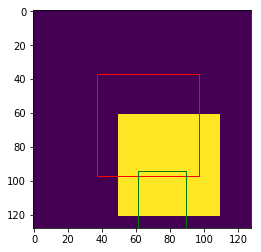

pred box loc:   variable(61.14493179321289) variable(94.11210632324219)
gt variable([[ 50.  61.  60.  60.   1.   0.]])


 20%|██        | 100/500 [00:44<03:01,  2.21it/s]

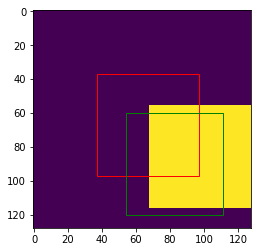

pred box loc:   variable(54.08785629272461) variable(59.900238037109375)
gt variable([[ 68.  56.  60.  60.   1.   0.]])


 40%|████      | 200/500 [01:30<02:14,  2.23it/s]

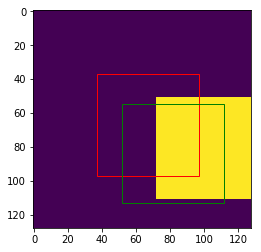

pred box loc:   variable(52.014808654785156) variable(54.64373779296875)
gt variable([[ 72.  51.  60.  60.   1.   0.]])


 60%|██████    | 300/500 [02:14<01:28,  2.25it/s]

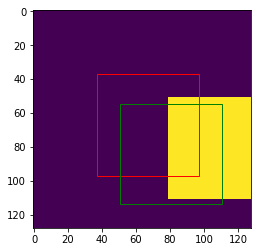

pred box loc:   variable(50.49454116821289) variable(54.6655158996582)
gt variable([[ 79.  51.  60.  60.   1.   0.]])


 80%|████████  | 400/500 [02:59<00:44,  2.25it/s]

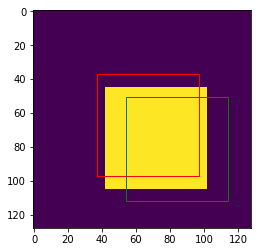

pred box loc:   variable(53.90179443359375) variable(50.38911437988281)
gt variable([[ 42.  45.  60.  60.   1.   0.]])


100%|██████████| 500/500 [03:43<00:00,  2.21it/s]


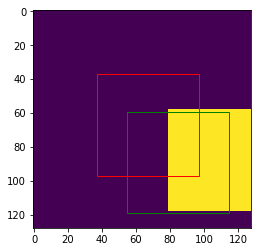

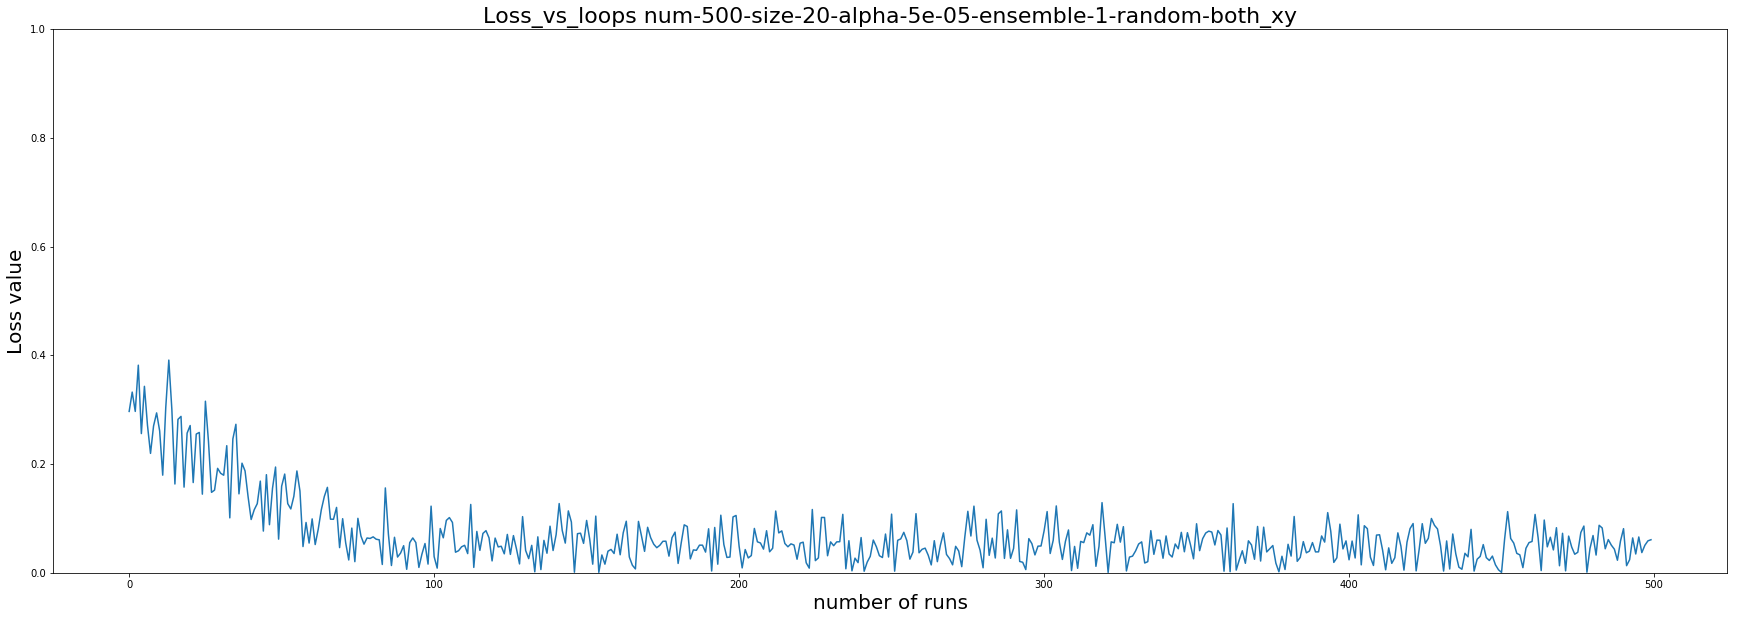

(1, 500, 1)

In [33]:
all_losses = []
alpha = 0.00005
locx= np.random.randint(10, 60) 
locy= np.random.randint(10, 60) 
size= 20
nloops= 500
ensemble = 1
posdiff = 50

for i in range(ensemble): 

    locx= np.random.randint(10, 90) 
    locy= np.random.randint(10, 90) 

    loss_history, pred_boxes, def_boxes, ground_truth, image,boxnet = all_connected(locx,locy, size,size, alpha, nloops, posdiff)
    
    
    ax=draw_boxes(image,def_boxes)
    draw_pred_boxes(pred_boxes, image, ax)
    all_losses.append(loss_history)

    
    random_or_not = 'both_xy'
    plt.figure(figsize=(30,10))
    plt.xlabel('number of runs', size =20)
    plt.ylabel('Loss value', size =20)
    title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
    plt.title(title_name, size=22 )
    plt.ylim([0,1])
    plt.plot(range(len(loss_history)), loss_history)
    # plt.savefig(title_name+'.png')
    plt.show()
    
    
    
    
    
    
    
    
all_losses = np.array(all_losses)
all_losses2 = all_losses.transpose()
all_losses2.shape  


    

  0%|          | 0/500 [00:00<?, ?it/s]

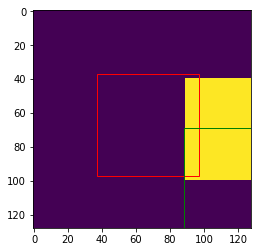

pred box loc:   variable(88.06483459472656) variable(68.5203857421875)
gt variable([[ 89.  40.  60.  60.   1.   0.]])


 20%|██        | 100/500 [00:44<02:58,  2.25it/s]

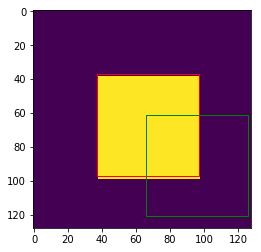

pred box loc:   variable(65.89286041259766) variable(61.10093688964844)
gt variable([[ 38.  39.  60.  60.   1.   0.]])


 40%|████      | 200/500 [01:29<02:14,  2.24it/s]

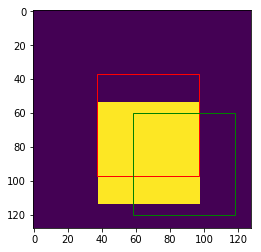

pred box loc:   variable(58.430877685546875) variable(60.14517593383789)
gt variable([[ 38.  54.  60.  60.   1.   0.]])


 60%|██████    | 300/500 [02:14<01:29,  2.24it/s]

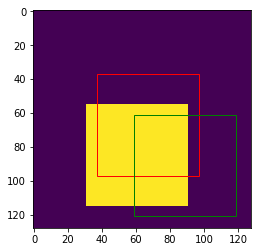

pred box loc:   variable(59.053871154785156) variable(61.16929626464844)
gt variable([[ 31.  55.  60.  60.   1.   0.]])


 80%|████████  | 400/500 [02:58<00:44,  2.25it/s]

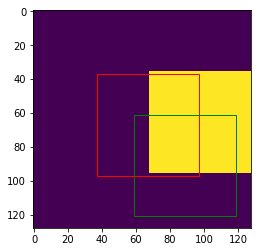

pred box loc:   variable(58.67354202270508) variable(60.899009704589844)
gt variable([[ 68.  36.  60.  60.   1.   0.]])


100%|██████████| 500/500 [03:43<00:00,  2.25it/s]


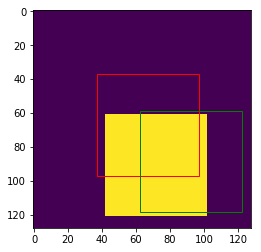

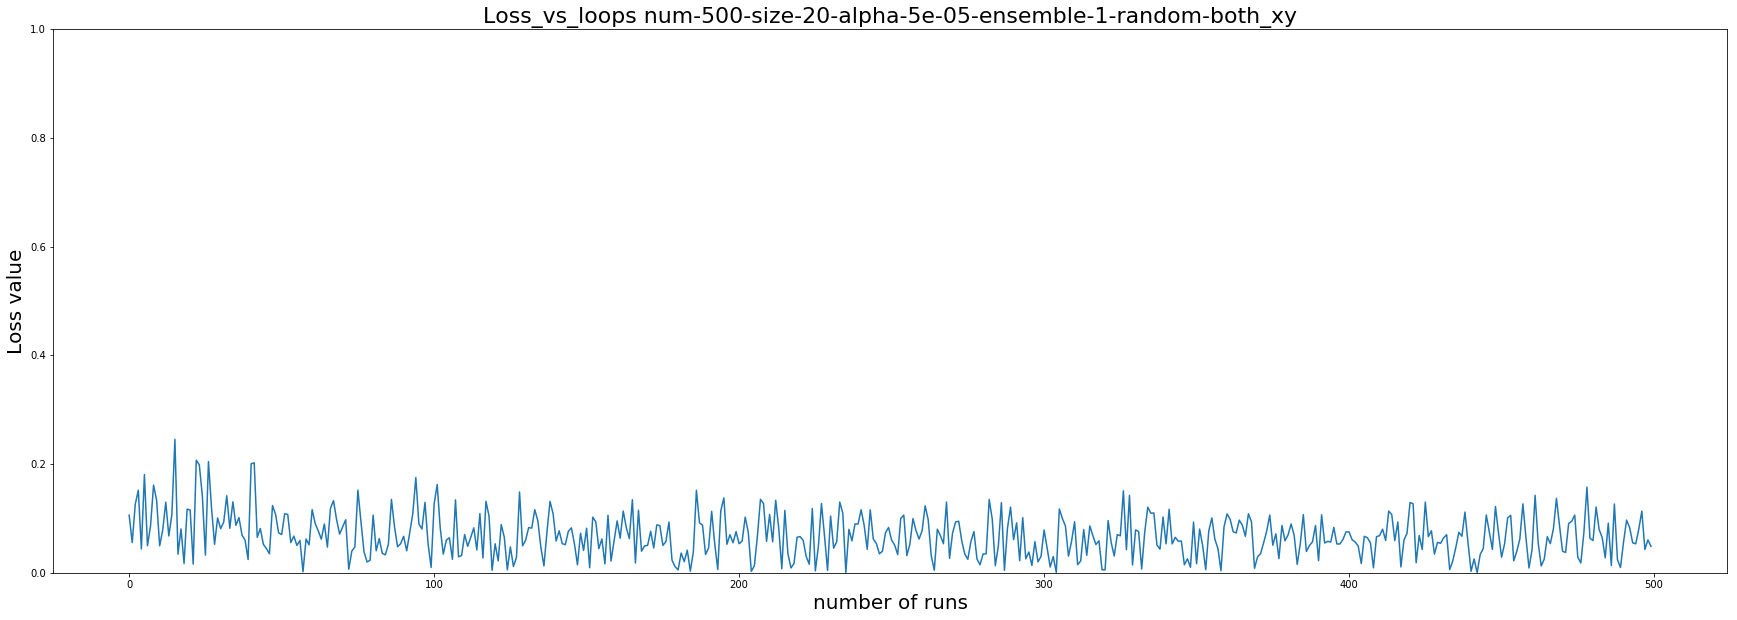

(1, 500, 1)

In [34]:
all_losses = []
alpha = 0.00005
locx= np.random.randint(10, 60) 
locy= np.random.randint(10, 60) 
size= 20
nloops= 500
ensemble = 1
posdiff = 60

for i in range(ensemble): 

    locx= np.random.randint(10, 90) 
    locy= np.random.randint(10, 90) 

    loss_history, pred_boxes, def_boxes, ground_truth, image,boxnet = all_connected(locx,locy, size,size, alpha, nloops, posdiff)
    
    
    ax=draw_boxes(image,def_boxes)
    draw_pred_boxes(pred_boxes, image, ax)
    all_losses.append(loss_history)

    
    random_or_not = 'both_xy'
    plt.figure(figsize=(30,10))
    plt.xlabel('number of runs', size =20)
    plt.ylabel('Loss value', size =20)
    title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
    plt.title(title_name, size=22 )
    plt.ylim([0,1])
    plt.plot(range(len(loss_history)), loss_history)
    # plt.savefig(title_name+'.png')
    plt.show()
    
    
    
    
    
    
    
    
all_losses = np.array(all_losses)
all_losses2 = all_losses.transpose()
all_losses2.shape  


    


In [35]:
def_boxes

variable([[ 67.17212677,  67.17212677,  60.        ,  60.        ,
             0.        ,   0.        ]])

In [36]:
size_list

NameError: name 'size_list' is not defined